In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../scripts')
import numerics
import cdd
import torch
from importlib import reload
import style
from os.path import join
reload(numerics)

ModuleNotFoundError: No module named 'cdd'

In [2]:
b_vals = np.array([1.5, 2., 2.5])
g_vals = np.linspace(0., 4., 2500)
colors = ['0.0', '0.4', '0.8']

def compute_dmft_curves():
    all_A = []
    all_A_fp = []
    all_Delta_diffs = []
    
    for b_idx in range(len(b_vals)):
        b = b_vals[b_idx]
        Delta_0 = numerics.compute_psi_inv(1./b)
        Delta_inf = np.array([numerics.compute_Delta_inf(Delta_0, g_vals[i]) for i in range(len(g_vals))])
        A = numerics.compute_A(Delta_inf, Delta_0, g_vals)
        A[A < 0] = np.nan
        
        A_fp = numerics.compute_A(Delta_0, Delta_0, g_vals)
        A_fp[A_fp < 0] = np.nan
        
        Delta_diff = Delta_0-Delta_inf
        
        all_A.append(A)
        all_A_fp.append(A_fp)
        all_Delta_diffs.append(Delta_diff)
    return all_A, all_A_fp, all_Delta_diffs


from scipy.integrate import odeint
def integrate_potential(Delta_0, Delta_inf, g, A):
    def dy_dt(y, t):
        Delta, Delta_dot = y[0], y[1]
        V_deriv = numerics.compute_V_deriv(
            Delta_inf=Delta_inf, Delta_0=Delta_0, Delta=Delta, g=g, A=A)
        y_dot = np.array([Delta_dot, -V_deriv])
        return y_dot
    t_vals = np.linspace(0, 40, 1000)
    out = odeint(dy_dt, y0=np.array([Delta_0, 0.]), t=t_vals, rtol=1e-12)
    return t_vals, out[:, 0]
    
all_A, all_A_fp, all_Delta_diffs = compute_dmft_curves()

/home/davidclark/Projects/Subspace/paper-notebooks/../scripts/numerics.py:25: RuntimeWarning: invalid value encountered in sqrt
  t1 = np.sqrt(A - Delta**2)


In [3]:
g_vals_for_potential = (1.5, 2.25, 2.6)
colors = ['red', 'blue', 'black']
labels = ["chaos suppressed", "chaos\n w/ structure", "chaos"]

def plot_A_sqrt_curves(ax):
    for b_idx in range(len(b_vals)):
        b = b_vals[b_idx]
        A, A_fp, Delta_diff = all_A[b_idx], all_A_fp[b_idx], all_Delta_diffs[b_idx]
        idx = np.argmax((Delta_diff > 1e-3) & (Delta_diff < 1e-1))
        ax.plot(g_vals[:idx], np.sqrt(A[:idx]), c='red')
        ax.plot(g_vals[idx-1:], np.sqrt(A[idx-1:]), c='blue')
        ax.plot(g_vals[idx:], np.sqrt(A_fp)[idx:], color='blue', ls='--')
        ax.scatter(g_vals[idx], np.sqrt(A[idx]), lw=0,
                    color='black', zorder=1000, s=5)
        if b_idx == 2:
            ii = 0
            for g in g_vals_for_potential:
                i = np.argmin((g_vals-g)**2)
                x_pt, y_pt = g_vals[i], 0.05+(np.sqrt(A)[i] if g < 2.5 else 0.)
                ax.scatter(x_pt, y_pt,
                            zorder=100, lw=0, s=15, color=colors[ii], marker='X')
                ax.text(x_pt+0.025, y_pt+0.025, labels[ii], color=colors[ii], fontsize=6)
                ii += 1
        ax.text(0.025, np.sqrt(A[0])+0.01, "$b={}$".format(b), fontsize=6, va='bottom', ha='left')
    ax.set_ylim(0, 2)
    ax.set_xlim(0, 3)
    ax.set_yticks([0, 1, 2])
    ax.set_xlabel("$g$", labelpad=1)
    ax.set_ylabel("$\sqrt{A^{\mu}}$", labelpad=5, va='center')#, fontsize=6)
    
def plot_potentials(ax):
    b = b_vals[-1]
    i = 0
    for g in g_vals_for_potential:
        if g < 2.4:
            Delta_0 = numerics.compute_psi_inv(1./b)
            Delta_inf = numerics.compute_Delta_inf(Delta_0, g)
            A = numerics.compute_A(Delta_inf, Delta_0, g)
        else:
            Delta_0 = numerics.compute_Delta_0_sompolinsky(g=g)
            Delta_inf = 0.
            A = 0.
        t, D = integrate_potential(Delta_0, Delta_inf, g, A)
        if g < 1.9:
            D[:]  = D[0]
        ax.plot(t, D, color=colors[i], lw=1.2)
        i += 1
    ax.set_ylim(0, 4.5)
    ax.set_ylabel("$\Delta^{\mu}(\\tau)$", va='center', labelpad=5)
    ax.set_xlabel("$\\tau$", labelpad=1)
    ax.set_xlim(t[0], t[-1])
    ax.set_yticks([0, 1, 2, 3, 4])

    

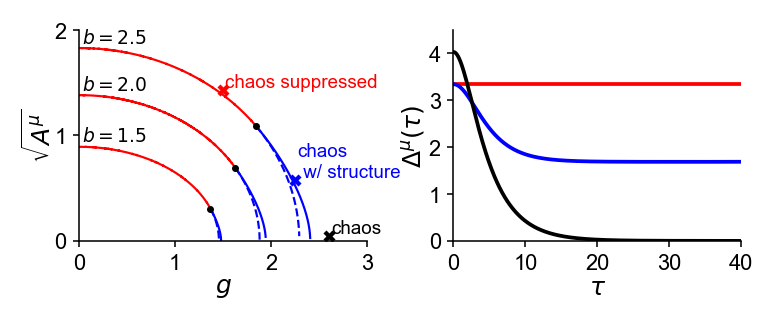

In [4]:
#NUMBERS FROM "fixed_points" notebook
#Just need to calculate net_lpad and net_rpad
fig_width = 3.375
fig_lpad = 0.125
fig_rpad = 0.125
subfig_width = (fig_width-fig_lpad-fig_rpad) / 3
lpad = 0.15
rpad = 0.025
net_lpad = (fig_lpad + lpad*subfig_width)/fig_width
net_rpad = (fig_rpad + rpad*subfig_width)/fig_width

fig, axes = plt.subplots(1, 2, figsize=(3.375, 1.25))
fig.subplots_adjust(left=net_lpad, right=1-net_rpad, top=0.95, bottom=0.2, wspace=0.3)

plot_A_sqrt_curves(axes[0])
plot_potentials(axes[1])

plt.savefig("../figs/dmft.pdf")